# TUTORIAL 7 - NEUROMORPHIC DATASETS WITH TONIC + SNNTORCH

In this tutorial you will:
+ Learn how to load neuromorphic datasets using [`Tonic`](https://tonic.readthedocs.io/en/latest/index.html)
+ Make use of caching to speed up dataloading.
+ Train a CSNN with [Neuromorphic-MNIST](https://tonic.readthedocs.io/en/latest/generated/tonic.datasets.NMNIST.html)

## 1. USING TONIC TO LOAD NEUROMORPHIC DATASETS
Loading datasets from neuromorphic sensor  is made super simple thanks to `Tonic`, which works much like Pytorch's `torchvision`.
Lets start by loading the Neuromorphic-MNIST, called `N-MNIST`, and look at some raw samples to get a feel of the data we are working with.

In [1]:
import tonic

data_path = '/tmp/data/nmnist'
dataset = tonic.datasets.NMNIST(save_to=data_path, train=True)

events, target = dataset[0]  # get the first sample

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Now let's take a look at the events and target
print(f"Target label: {target}")
print(f"Events shape: {events.shape}")
print(f"First 5 events:\n{events[:5]}")

Target label: 0
Events shape: (5028,)
First 5 events:
[(10, 30,  937, 1) (33, 20, 1030, 1) (12, 27, 1052, 1) (33,  3, 2078, 1)
 (14, 23, 2383, 0)]


The dataset has 5028 rows, each representing an asynchronous event from the sensor. The shape of each event is a tuple of 4 values: `(x, y, timestamp, polarity)`:

+ `x` and `y` correspond to the address (pixel) of the event on a 34x34 grid.
+ `timestamp` is the time at which the event occurred, in microseconds.
+ `polarity` refers to whether an on-spike (+1) or off-spike (-1) event occurred; i.e., whether the brightness at that pixel increased or decreased.

We can accumulate thos events over time and plot the bins as an image. It looks like this:

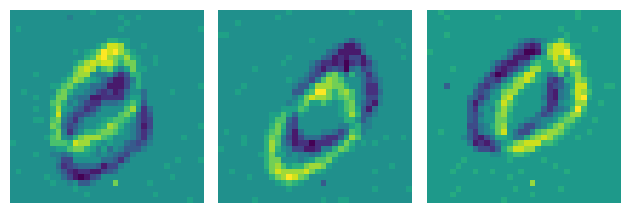

In [3]:
tonic.utils.plot_event_grid(events)

### 1.1 TRANSFORMATIONS
Neuroal networks, cannot take a list of sparse events as input. The raw data must be converted into a suitable representation, such as a tensor. Using the `dataset` class in `tonic`, we can apply transformations to the raw data, similar to how we would do it in `torchvision`. 
The neuromorphic camera sensor has a temporal resolution of microseconds, which when converted directly into a tensor, ends up as a very large tensor. Instead, we can bin the events into a smaller number of time bins (time windows). This **reduces temporal precision, but allows us to work in a dense format**

+ `timewindow=1000` integrates events over 1000 $\mu s$ (1 ms) bins.
+ Denoise removes isolated, one-off events. If no event occurrs within a neighborhood of 1 pixel across `filter_time` $\mu s$, the event is removed. A smaller `filter_time` will remove more events.

**These transforms set how the dataset is saved to disk**

In [4]:
sensor_size = tonic.datasets.NMNIST.sensor_size  # (34, 34)
print(f"Sensor size: {sensor_size}")

# Denoise and bin settings
filter_time = 10E3  # 10000 microseconds = 10 milliseconds
timewindow = 1000  # 1000 microseconds = 1 millisecond

frame_transform = tonic.transforms.Compose([
    tonic.transforms.Denoise(filter_time=filter_time),
    tonic.transforms.ToFrame(sensor_size=sensor_size, time_window=timewindow)
])

train_dataset = tonic.datasets.NMNIST(save_to=data_path, 
                                      train=True, 
                                      transform=frame_transform)

test_dataset = tonic.datasets.NMNIST(save_to=data_path, 
                                     train=False, 
                                     transform=frame_transform)

Sensor size: (34, 34, 2)


### 1.2 CACHING - SPEEDING UP DATA LOADING
The first time you load a dataset, it can take a while to apply the transformations to all the samples. To speed up subsequent loading, we can use caching. This stores the transformed samples on disk, so that they can be loaded quickly next time.

Because event recordings have different lengths, we need to pad the shorter ones with zeros to make them all the same length. This is done using a custom `collate` function. `tonic.collation.PadTensors` pads the tensors to the length of the longest tensor in the batch, ensuring that all tensors in the batch have the same shape.

In [5]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

cached_path = "/tmp/cached/nmnist"
cached_train_dataset = DiskCachedDataset(train_dataset, 
                                         cache_path=cached_path+'/train')

cached_test_dataset = DiskCachedDataset(test_dataset, 
                                        cache_path=cached_path+'/test')

### 1.3 DATALOADER
We can now create a dataloader to load the dataset in batches. This is done using `torch.utils.data.DataLoader`, just like with any other dataset in PyTorch. In addition, we will use `torchvision.transforms` to add some augmentations.

**Note:** In contrary to images, the values of the events tensor are `[-1, 0, 1]`, so normalization is not needed.

In [6]:
import torch
import torchvision

def apply_transforms(data, targets):
    return transforms(data), targets

transforms = tonic.transforms.Compose([
    torch.from_numpy,
    torchvision.transforms.RandomRotation([-10, 10])
])

batch_size = 128

cached_train_dataset = DiskCachedDataset(train_dataset, 
                                         cache_path=cached_path+'/train',
                                         transforms=apply_transforms)

cached_test_dataset = DiskCachedDataset(test_dataset, 
                                        cache_path=cached_path+'/test')

train_loader = DataLoader(cached_train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True,
                          num_workers=8,
                          collate_fn=tonic.collation.PadTensors (batch_first=False)
)
test_loader = DataLoader(cached_test_dataset, 
                         batch_size=batch_size, 
                         num_workers=8,
                         collate_fn=tonic.collation.PadTensors(batch_first=False),
                         shuffle=False
)

Now lets see what we get from each mini-batch:

In [7]:
event_tensor, target = next(iter(train_loader))
print(f"Batch event tensor shape: {event_tensor.shape}")

Batch event tensor shape: torch.Size([311, 128, 2, 34, 34])


## 2.1 DEFINE THE CSNN MODEL
We will use `snnTorch`+`PyTorch` to construct a CSNN. The covolutional network atchitecture to be used is: 12C5-MP2-32C5-MP2-800FC10.
+ 12C5: Convolutional layer with 12 output channels and a kernel size of 5x5.
+ MP2: Max pooling layer with a kernel size of 2x2.
+ 32C5: Convolutional layer with 32 output channels and a kernel size of 5x5.
+ MP2: Max pooling layer with a kernel size of 2x2.
+ 800FC: Fully connected layer with 800 output neurons.

We are going to use the `Sequential` container to simplify the model definition. 

In [8]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.nn as nn

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Spiking Neuron Parameters
spike_grad = surrogate.atan()  # surrogate gradient function
beta = 0.5  # neuron decay rate

# Initialize Network
net = nn.Sequential(
    nn.Conv2d(2, 12, kernel_size=5),  # 12C5
    nn.MaxPool2d(2),                 # MP2
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Conv2d(12, 32, kernel_size=5), # 32C5
    nn.MaxPool2d(2),                 # MP2
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
    nn.Flatten(),                    # flatten
    nn.Linear(32*5*5, 10),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
).to(device)

Using device: cuda


Now, let's define the forward pass. 

+ The first step is to initialize the hidden states of the spiking neurons (set membrane potentials to zero). This is done using `ssntorch.utils.reset`. 
+ Next we will iterate over the time dimension of the input tensor, passing each time slice through the network, and collecting the output spikes.



In [10]:
def forward_pass(net, data):
    spk_rec = []
    utils.reset(net)  # reset hidden states at the start of each forward pass

    for step in range(data.size(0)):  # iterate over time dimension
        spk_out, mem_out = net(data[step])  # forward pass
        spk_rec.append(spk_out)  # collect output spikes

    return torch.stack(spk_rec)  # return stacked spikes over time

## 2.2 TRAINING
In the preivious tutorial, `Cross Entropy Loss` was applied to the **total** spike count to maximize the number of spikes from the correct class.

Another approach, would be to encourage the neuron of the correct class to elicit spikes 80% of the time, and 20% of the time from the incorrect classes. This effictively targets a certain firing rate for each class. This can be achieved with `snn.functional.mse_count_loss`.

In [11]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))
loss_func = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

### 2.2.1 TRAINING LOOP

In [12]:
from tqdm import tqdm

num_epochs = 3

loss_hist = []
acc_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    p_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_idx, (data, targets) in enumerate(p_bar):
        data = data.float().to(device)
        targets = targets.to(device)

        spk_rec = forward_pass(net, data)
        loss_val = loss_func(spk_rec, targets)
        acc = SF.accuracy_rate(spk_rec, targets)

        # Backpropagation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        epoch_loss += loss_val.item()
        epoch_acc += acc.item()

        p_bar.set_postfix(loss=epoch_loss/(batch_idx+1), 
                          acc=epoch_acc/(batch_idx+1))

    loss_hist.append(epoch_loss / len(train_loader))
    acc_hist.append(epoch_acc / len(train_loader))

    test_loss = 0.0
    test_acc = 0.0
    net.eval()
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.float().to(device)
            targets = targets.to(device)

            spk_rec = forward_pass(net, data)
            loss_val = loss_func(spk_rec, targets)
            acc = SF.accuracy_rate(spk_rec, targets)

            test_loss += loss_val.item()
            test_acc += acc.item()

    test_loss_hist.append(test_loss / len(test_loader))
    test_acc_hist.append(test_acc / len(test_loader))
    print(f"Test Loss: {test_loss_hist[-1]:.4f}, Test Acc: {test_acc_hist[-1]:.4f}")

Epoch 1/3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/3: 100%|██████████| 469/469 [05:11<00:00,  1.50it/s, acc=0.6, loss=10.2]  


Test Loss: 4.2066, Test Acc: 0.8708


Epoch 2/3: 100%|██████████| 469/469 [05:40<00:00,  1.38it/s, acc=0.883, loss=3.88]


Test Loss: 3.3086, Test Acc: 0.9211


Epoch 3/3: 100%|██████████| 469/469 [05:51<00:00,  1.33it/s, acc=0.919, loss=3.08]


Test Loss: 2.5294, Test Acc: 0.9441


## 3. RESULTS

## 3.1 PLOT TRAIN AND TEST LOSS AND ACCURACY

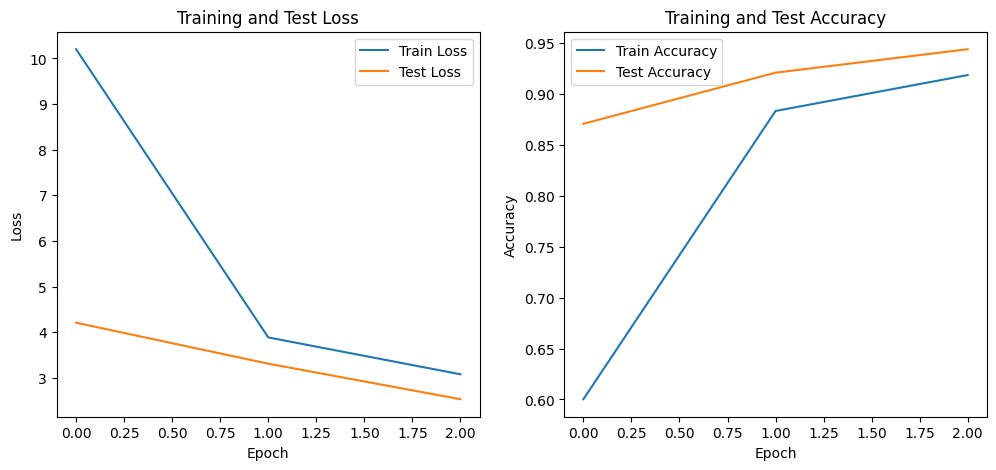

In [13]:
import matplotlib.pyplot as plt

# Plot train and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_hist, label='Train Loss')
plt.plot(test_loss_hist, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot train and test accuracy
plt.subplot(1, 2, 2)
plt.plot(acc_hist, label='Train Accuracy')
plt.plot(test_acc_hist, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

## 3.2 SPIKE COUNTER
Now, let's run a forward pass on a batch of data, and obtain the spike recording.

The correct class, should have the at least 80% of the spikes.

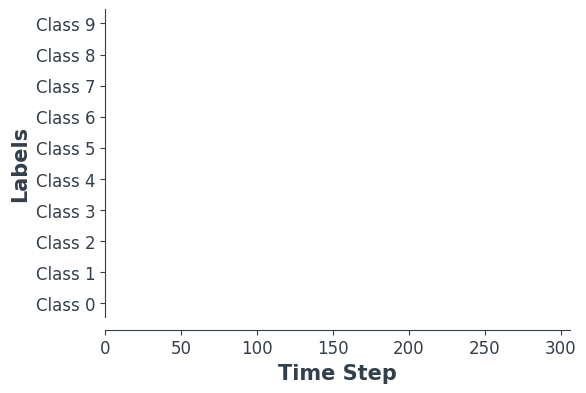

In [17]:
from IPython.display import HTML
from snntorch import spikeplot as splt

idx = 0  # index of the sample in the batch
labels = [f"Class {i}" for i in range(10)]

# Plot spike counts histogram
fig, ax = plt.subplots(1,1, figsize=(6, 4))  # Only one axis
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, 
                       labels=labels, 
                       animate=True, 
                       interpolate=4)
HTML(anim.to_html5_video())

In [18]:
print(f"True target label: {targets[idx].item()}")

True target label: 9
